In [1]:
import os
import glob
import json
import pandas as pd

# -------------------------------
# 輔助函式：讀取 JSON 檔案
# -------------------------------
def load_json_data(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

# -------------------------------
# 輔助函式：建立函式資訊 mapping
# -------------------------------
def build_func_info(pcode_dict, func_names):
    """
    建立 mapping：函式名稱 -> (地址, opcode 集合)
    參數：
      - pcode_dict：{ address: [pcode_line, ...], ... }
      - func_names：{ address: function_name, ... }
    這個函式依據每個函式的 pcode 行，抽取出 opcode（根據 tokens 的位置判斷）。
    """
    info = {}
    for addr, lines in pcode_dict.items():
        name = func_names.get(addr, addr)
        opcode_set = set()
        for line in lines:
            tokens = line.split()
            if tokens:
                # 依據原本邏輯判斷：
                if tokens[0].startswith('(') and len(tokens) > 3:
                    opcode_set.add(tokens[3])
                elif len(tokens) > 1:
                    opcode_set.add(tokens[1])
        info[name] = (addr, opcode_set)
    return info

# -------------------------------
# 主程式：讀取資料並進行統計分析
# -------------------------------

# 請依實際環境調整 RESULTS_DIR
# 例如：資料目錄結構為 ../results/20250210_113636/ 下有 arm 與 mips 目錄
RESULTS_DIR = "../results"
COMPARE_DIR = os.path.join(RESULTS_DIR, "compare")
os.makedirs(COMPARE_DIR, exist_ok=True)

# 找出 RESULTS 目錄下的 timestamp 子目錄（排除 compare 資料夾）
timestamp_dirs = [d for d in os.listdir(RESULTS_DIR)
                  if os.path.isdir(os.path.join(RESULTS_DIR, d)) and d.lower() != "compare"]

if not timestamp_dirs:
    print("找不到 timestamp 目錄")
    exit(1)

timestamp_dirs.sort()
all_stats = []

for ts in timestamp_dirs:
    ts_path = os.path.join(RESULTS_DIR, ts)
    # 預期每個 timestamp 目錄下都有 arm 與 mips 目錄
    arm_path = os.path.join(ts_path, "arm")
    mips_path = os.path.join(ts_path, "mips")
    
    if not os.path.isdir(arm_path) or not os.path.isdir(mips_path):
        print(f"{ts} 下找不到 arm 或 mips 目錄")
        continue

    # 讀取 ARM 目錄下的 JSON 檔案（假設只有一個檔案）
    arm_files = glob.glob(os.path.join(arm_path, "*"))
    if not arm_files:
        print(f"{ts} 下 arm 目錄中找不到檔案")
        continue
    data_arm = load_json_data(arm_files[0])
    
    # 讀取 MIPS 目錄下的 JSON 檔案
    mips_files = glob.glob(os.path.join(mips_path, "*"))
    if not mips_files:
        print(f"{ts} 下 mips 目錄中找不到檔案")
        continue
    data_mips = load_json_data(mips_files[0])
    
    # 依照指定方式讀取 pcode 與 func_names
    pcode_arm = data_arm.get("pcode", {})
    func_names_arm = data_arm.get("func_names", {})
    pcode_mips = data_mips.get("pcode", {})
    func_names_mips = data_mips.get("func_names", {})
    
    # 建立每個架構的函式資訊 mapping
    arm_info = build_func_info(pcode_arm, func_names_arm)
    mips_info = build_func_info(pcode_mips, func_names_mips)
    
    # 統計各項數據
    arm_total = len(arm_info)
    mips_total = len(mips_info)
    common_funcs = set(arm_info.keys()) & set(mips_info.keys())
    unique_arm = set(arm_info.keys()) - common_funcs
    unique_mips = set(mips_info.keys()) - common_funcs
    
    print(f"Timestamp: {ts}")
    print("  ARM 總函式數量:", arm_total)
    print("  MIPS 總函式數量:", mips_total)
    print("  共同函式數量:", len(common_funcs))
    print("  僅 ARM 的函式數量:", len(unique_arm))
    print("  僅 MIPS 的函式數量:", len(unique_mips))
    print("-" * 50)
    
    all_stats.append({
        "Timestamp": ts,
        "ARM 總函式數量": arm_total,
        "MIPS 總函式數量": mips_total,
        "共同函式數量": len(common_funcs),
        "僅 ARM 的函式數量": len(unique_arm),
        "僅 MIPS 的函式數量": len(unique_mips)
    })

# 將統計結果合併成 DataFrame 並存成 CSV
df_stats = pd.DataFrame(all_stats)
output_csv = os.path.join(COMPARE_DIR, "function_statistics_all.csv")
df_stats.to_csv(output_csv, index=False)
print(f"所有統計結果已儲存到: {output_csv}")


Timestamp: 20250210_113636
  ARM 總函式數量: 1040
  MIPS 總函式數量: 1073
  共同函式數量: 919
  僅 ARM 的函式數量: 121
  僅 MIPS 的函式數量: 154
--------------------------------------------------
所有統計結果已儲存到: ../results/compare/function_statistics_all.csv


In [2]:
from collections import defaultdict
import pandas as pd

def classify_function(func_name):
    """
    根據函式名稱的字串模式，將函式分類為特定類別。
    這裡的分類規則是根據簡單的子字串判斷，使用者可依需求自行擴充或調整。
    """
    name = func_name.lower()
    if "attack" in name:
        return "Attack"
    elif "pthread" in name:
        return "Threading"
    elif "gconv" in name:
        return "Conversion"
    elif name.startswith("_io") or "io_" in name:
        return "IO"
    elif "dl" in name:
        return "Dynamic Linker"
    elif "malloc" in name or "arena" in name or "ptmalloc" in name:
        return "Memory"
    elif "syscall" in name:
        return "System Call"
    elif "libc" in name:
        return "Libc"
    elif "util" in name:
        return "Utility"
    elif "socket" in name or "inet" in name:
        return "Networking"
    else:
        return "Other"

def classify_functions(func_set):
    """
    輸入一個函式名稱集合，回傳一個 dict，key 為分類名稱，
    value 為該分類下的函式名稱列表。
    """
    categories = defaultdict(list)
    for func in func_set:
        cat = classify_function(func)
        categories[cat].append(func)
    return categories

# 假設 common_funcs, unique_arm, unique_mips 這三個集合已經從前面的資料統計中取得：
# 例如:
# common_funcs = set(arm_info.keys()) & set(mips_info.keys())
# unique_arm = set(arm_info.keys()) - common_funcs
# unique_mips = set(mips_info.keys()) - common_funcs

# 分類統計
common_cats = classify_functions(common_funcs)
unique_arm_cats = classify_functions(unique_arm)
unique_mips_cats = classify_functions(unique_mips)

def print_classification_stats(cat_dict, group_name):
    print(f"=== {group_name} ===")
    total = 0
    for cat, funcs in cat_dict.items():
        count = len(funcs)
        total += count
        print(f"{cat:20s}: {count:3d}")
    print(f"Total {group_name}: {total}\n")

# 印出統計結果
print_classification_stats(common_cats, "共同函式")
print_classification_stats(unique_arm_cats, "僅 ARM 函式")
print_classification_stats(unique_mips_cats, "僅 MIPS 函式")

# 如果想把分類結果存成 CSV 檔，可以將結果轉換成 DataFrame 後輸出
def dict_to_dataframe(cat_dict, group_name):
    rows = []
    for cat, funcs in cat_dict.items():
        for func in funcs:
            rows.append({
                "Group": group_name,
                "Category": cat,
                "Function": func
            })
    return pd.DataFrame(rows)

df_common = dict_to_dataframe(common_cats, "Common")
df_unique_arm = dict_to_dataframe(unique_arm_cats, "ARM Only")
df_unique_mips = dict_to_dataframe(unique_mips_cats, "MIPS Only")

df_all = pd.concat([df_common, df_unique_arm, df_unique_mips], ignore_index=True)

# 儲存 CSV（請依需求修改路徑）
output_csv = "function_classification.csv"
df_all.to_csv(output_csv, index=False)
print(f"分類結果已儲存到 {output_csv}")


=== 共同函式 ===
Other               : 465
Utility             :  16
Conversion          :  42
Threading           :  25
IO                  : 132
Dynamic Linker      : 148
Attack              :  20
Memory              :  22
Libc                :  43
Networking          :   5
System Call         :   1
Total 共同函式: 919

=== 僅 ARM 函式 ===
Other               : 118
Dynamic Linker      :   3
Total 僅 ARM 函式: 121

=== 僅 MIPS 函式 ===
Other               : 135
Threading           :  10
Memory              :   1
Dynamic Linker      :   4
Networking          :   2
System Call         :   2
Total 僅 MIPS 函式: 154

分類結果已儲存到 function_classification.csv


In [5]:
import pandas as pd
from collections import defaultdict
import statistics

def classify_function(func_name):
    """
    改進版的分類函式，根據函式名稱中的關鍵字來決定分類。
    使用者可根據實際情況調整判斷條件。
    """
    name = func_name.lower()
    # Attack: 例如包含 "attack"
    if "attack" in name:
        return "Attack"
    # Threading: 包含 "pthread" 或 "thread"
    elif "pthread" in name or "thread" in name:
        return "Threading"
    # Conversion: 包含 "gconv"、"conv"、"translit" 等
    elif "gconv" in name or "transliterate" in name or "convert" in name:
        return "Conversion"
    # IO: 若名稱包含常見 IO 字串，如 _io 開頭、含有 "file", "read", "write", "fputs", "fgets", "flush"
    elif name.startswith("_io") or "io_" in name or "file" in name or "read" in name or "write" in name or "fputs" in name or "fgets" in name or "flush" in name:
        return "IO"
    # Dynamic Linker: 包含 "dl", "dlsym", "dlopen", "dlclose", "dlerror"（注意：此條件必須放在 Memory 之前）
    elif "dl" in name or "dlsym" in name or "dlopen" in name or "dlclose" in name or "dlerror" in name:
        return "Dynamic Linker"
    # Memory: 包含 "malloc", "arena", "free", "realloc", "memalign", "memmove", "memcpy", "munmap", "brk", "sbrk", "valloc"
    elif any(x in name for x in ["malloc", "arena", "free", "realloc", "memalign", "memmove", "memcpy", "munmap", "brk", "sbrk", "valloc"]):
        return "Memory"
    # System Call: 包含 "syscall", "ioctl", "select", "poll"
    elif any(x in name for x in ["syscall", "ioctl", "select", "poll"]):
        return "System Call"
    # Libc: 包含 "libc"
    elif "libc" in name:
        return "Libc"
    # Utility: 包含 "util", "helper", 或常見字串如 "copy", "strcmp", "strlen", "strdup", "strncpy", "strchr", "memcmp", "memset"
    elif any(x in name for x in ["util", "helper", "copy", "strcmp", "strlen", "strdup", "strncpy", "strchr", "memcmp", "memset"]):
        return "Utility"
    # Networking: 包含 "socket", "inet", "send", "recv", "connect", "bind", "listen", "accept"
    elif any(x in name for x in ["socket", "inet", "send", "recv", "connect", "bind", "listen", "accept"]):
        return "Networking"
    else:
        return "Other"

# 讀取 CSV 檔案（請確認路徑正確）
csv_path = "/home/tommy/cross-architecture/Experiment1/src/scripts_with-fno-common＿20250210/ghidra/automation_20250210/results/compare/pcode_similarity_20250210_113636_arm_vs_mips.csv"
df = pd.read_csv(csv_path)

print("讀取 CSV 資料筆數:", len(df))
print(df.head())

# 建立函式名稱到相似度分數的 mapping（以 ARM Function Name 為主）
common_similarity = {}
for idx, row in df.iterrows():
    func_name = row["ARM Function Name"]
    score = row["Similarity Score"]
    common_similarity[func_name] = score

# 根據分類函式，依類別彙整相似度分數
category_scores = defaultdict(list)
for func, score in common_similarity.items():
    cat = classify_function(func)
    category_scores[cat].append(score)

# 計算各分類的函式數量與平均相似度
stats = []
for cat, scores in category_scores.items():
    count = len(scores)
    avg_score = statistics.mean(scores) if scores else 0
    stats.append({
        "Category": cat,
        "Count": count,
        "Average Similarity": avg_score
    })

# 轉換成 DataFrame 並依平均相似度排序（由高到低）
df_stats = pd.DataFrame(stats)
df_stats = df_stats.sort_values(by="Average Similarity", ascending=False)
print("\n共同函式各分類平均相似度:")
print(df_stats)

# 儲存統計結果成 CSV（請依需求調整輸出路徑）
output_csv = "common_function_similarity_by_category.csv"
df_stats.to_csv(output_csv, index=False)
print(f"\n分類統計結果已儲存到 {output_csv}")


讀取 CSV 資料筆數: 919
  ARM Address       ARM Function Name MIPS Address      MIPS Function Name  \
0  0x0003dd94                   _Fork   0x00439bd0                   _Fork   
1  0x00038b28       _IO_adjust_column   0x00433218       _IO_adjust_column   
2  0x0005ca10      _IO_adjust_wcolumn   0x004623bc      _IO_adjust_wcolumn   
3  0x00039320             _IO_cleanup   0x00433a94             _IO_cleanup   
4  0x00038650  _IO_default_doallocate   0x00432c04  _IO_default_doallocate   

   Similarity Score  
0          0.266667  
1          1.000000  
2          1.000000  
3          0.909091  
4          1.000000  

共同函式各分類平均相似度:
          Category  Count  Average Similarity
10          Attack     20            0.898223
1               IO    174            0.890057
2   Dynamic Linker    146            0.851353
7             Libc     32            0.850644
5           Memory     59            0.833858
9          Utility     21            0.822530
0            Other    384            0.786851

In [9]:
import json
import os
import pandas as pd

# 指定 ARM 與 MIPS 的檔案路徑
arm_file = "/home/tommy/cross-architecture/Experiment1/src/scripts_with-fno-common＿20250210/ghidra/automation_20250210/results/20250210_113636/arm/mirai.arm"
mips_file = "/home/tommy/cross-architecture/Experiment1/src/scripts_with-fno-common＿20250210/ghidra/automation_20250210/results/20250210_113636/mips/mirai.mips"

def load_json(filepath):
    """讀取 JSON 檔案並回傳資料字典"""
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

# 讀取 ARM 與 MIPS 的結果檔案
arm_data = load_json(arm_file)
print("ARM 檔案中的 keys:", arm_data.keys())
mips_data = load_json(mips_file)

# 取得 function features 與 function names
# 注意：這邊的 func_features 其 key 為地址，而 func_names 提供地址對應的函式名稱
arm_features = arm_data.get("func_features", {})
mips_features = mips_data.get("func_features", {})

arm_func_names = arm_data.get("func_names", {})
mips_func_names = mips_data.get("func_names", {})

print("ARM function features 數量:", len(arm_features))
print("MIPS function features 數量:", len(mips_features))

# 將 ARM 的 function features 由地址轉換為以函式名稱為 key
arm_features_by_name = {}
for addr, features in arm_features.items():
    # 若在 func_names 中有對應的名稱，則取之；否則以地址作為名稱
    func_name = arm_func_names.get(addr, addr)
    arm_features_by_name[func_name] = features

# 將 MIPS 的 function features 由地址轉換為以函式名稱為 key
mips_features_by_name = {}
for addr, features in mips_features.items():
    func_name = mips_func_names.get(addr, addr)
    mips_features_by_name[func_name] = features

# 取得兩邊都有的函式（以函式名稱做比對）
common_funcs = set(arm_features_by_name.keys()) & set(mips_features_by_name.keys())
print("共同函式數量 (依函式名稱比較):", len(common_funcs))

# 將共同函式的特徵資料整合成一個 DataFrame
rows = []
for func in common_funcs:
    arm_feat = arm_features_by_name[func]    # 例如 [被呼叫數, 呼叫其他函數數, 參數個數, CBRANCH 數]
    mips_feat = mips_features_by_name[func]
    # 計算兩邊的差異（逐元素差值，可依需求計算歐式距離等）
    diff = [a - b for a, b in zip(arm_feat, mips_feat)]
    rows.append({
        "Function": func,
        "ARM Feature": arm_feat,
        "MIPS Feature": mips_feat,
        "Feature Difference": diff
    })

df_features = pd.DataFrame(rows)
print("\n前 5 筆共同函式的 function features 資料:")
print(df_features.head())


ARM 檔案中的 keys: dict_keys(['paramType', 'func_names', 'pcode', 'callees', 'func_features', 'callers'])
ARM function features 數量: 1049
MIPS function features 數量: 1106
共同函式數量 (依函式名稱比較): 919

前 5 筆共同函式的 function features 資料:
               Function    ARM Feature   MIPS Feature Feature Difference
0       decompose_rpath   [2, 5, 4, 0]   [3, 5, 4, 0]      [-1, 0, 0, 0]
1           util_memcpy   [8, 0, 3, 0]   [7, 0, 3, 0]       [1, 0, 0, 0]
2  __gconv_release_step   [3, 2, 1, 0]   [3, 2, 1, 0]       [0, 0, 0, 0]
3      __fstat64_time64  [12, 2, 2, 0]  [11, 1, 2, 0]       [1, 1, 0, 0]
4           check_match   [1, 1, 5, 0]   [1, 1, 5, 0]       [0, 0, 0, 0]


讀取 CSV 資料筆數: 919
  ARM Address       ARM Function Name MIPS Address      MIPS Function Name  \
0  0x0003dd94                   _Fork   0x00439bd0                   _Fork   
1  0x00038b28       _IO_adjust_column   0x00433218       _IO_adjust_column   
2  0x0005ca10      _IO_adjust_wcolumn   0x004623bc      _IO_adjust_wcolumn   
3  0x00039320             _IO_cleanup   0x00433a94             _IO_cleanup   
4  0x00038650  _IO_default_doallocate   0x00432c04  _IO_default_doallocate   

   Similarity Score  
0          0.266667  
1          1.000000  
2          1.000000  
3          0.909091  
4          1.000000  

前 5 筆 ARM 的 function features 資料:
                Function  Caller Count  Callee Count  Param Count  \
0  ___pthread_mutex_lock            13             4            1   
1              _int_free             4             8            3   
2     _dl_debug_vdprintf             6             4            4   
3          _IO_sputbackc             1             1            2   
4 

/tmp/ipykernel_2961727/427440832.py:111: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = pearsonr(df_merged["Pcode Similarity"], df_merged[col])


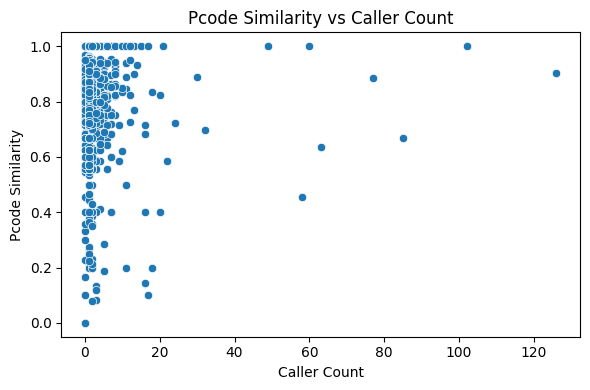

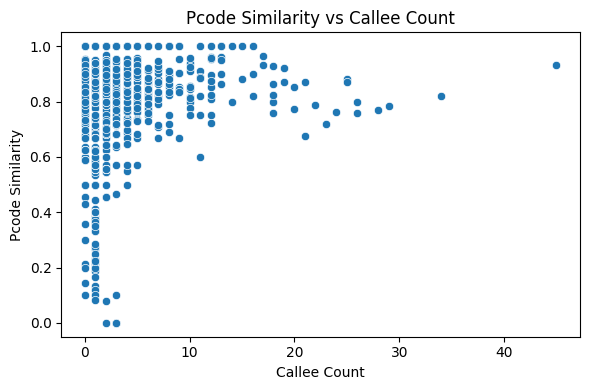

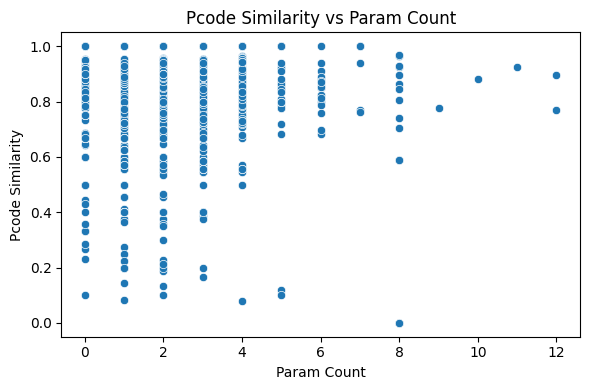

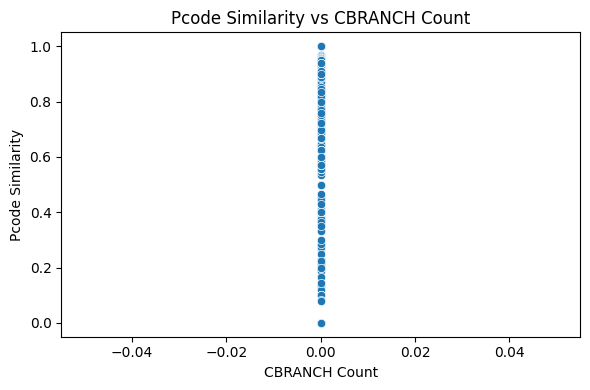


各分類統計結果:
                Pcode Similarity_mean  Pcode Similarity_count  \
Category                                                        
Attack                       0.898223                      20   
Conversion                   0.784924                      43   
Dynamic Linker               0.851353                     146   
IO                           0.890057                     174   
Libc                         0.850644                      32   
Memory                       0.833858                      59   
Networking                   0.723611                       9   
Other                        0.786851                     384   
System Call                  0.584267                       4   
Threading                    0.727760                      27   
Utility                      0.822530                      21   

                Caller Count_mean  Callee Count_mean  Param Count_mean  \
Category                                                              

In [13]:
import json
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# =============================
# 1. 定義分類函式（改進版）
# =============================
def classify_function(func_name):
    """
    根據函式名稱中的關鍵字來決定分類
    """
    name = func_name.lower()
    if "attack" in name:
        return "Attack"
    elif "pthread" in name or "thread" in name:
        return "Threading"
    elif "gconv" in name or "transliterate" in name or "convert" in name:
        return "Conversion"
    elif name.startswith("_io") or "io_" in name or "file" in name or "read" in name or "write" in name or "fputs" in name or "fgets" in name or "flush" in name:
        return "IO"
    elif "dl" in name or "dlsym" in name or "dlopen" in name or "dlclose" in name or "dlerror" in name:
        return "Dynamic Linker"
    elif any(x in name for x in ["malloc", "arena", "free", "realloc", "memalign", "memmove", "memcpy", "munmap", "brk", "sbrk", "valloc"]):
        return "Memory"
    elif any(x in name for x in ["syscall", "ioctl", "select", "poll"]):
        return "System Call"
    elif "libc" in name:
        return "Libc"
    elif any(x in name for x in ["util", "helper", "copy", "strcmp", "strlen", "strdup", "strncpy", "strchr", "memcmp", "memset"]):
        return "Utility"
    elif any(x in name for x in ["socket", "inet", "send", "recv", "connect", "bind", "listen", "accept"]):
        return "Networking"
    else:
        return "Other"

# =============================
# 2. 讀取 P-Code Similarity CSV 檔案
# =============================
csv_path = "/home/tommy/cross-architecture/Experiment1/src/scripts_with-fno-common＿20250210/ghidra/automation_20250210/results/compare/pcode_similarity_20250210_113636_arm_vs_mips.csv"
df_similarity = pd.read_csv(csv_path)
print("讀取 CSV 資料筆數:", len(df_similarity))
print(df_similarity.head())

# 建立以 ARM Function Name 為 key 的 similarity mapping
similarity_dict = {}
for idx, row in df_similarity.iterrows():
    func_name = row["ARM Function Name"]
    score = row["Similarity Score"]
    similarity_dict[func_name] = score

df_sim = pd.DataFrame(list(similarity_dict.items()), columns=["Function", "Pcode Similarity"])

# =============================
# 3. 讀取 ARM 的函式特徵資料（以函式名稱為 key）
# =============================
arm_file = "/home/tommy/cross-architecture/Experiment1/src/scripts_with-fno-common＿20250210/ghidra/automation_20250210/results/20250210_113636/arm/mirai.arm"
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

arm_data = load_json(arm_file)
# 注意：此處假設 ARM 的 JSON 檔中有 "func_features" 與 "func_names"
arm_features = arm_data.get("func_features", {})   # key: address, value: feature vector (list of 4 numbers)
arm_func_names = arm_data.get("func_names", {})       # key: address, value: function name

# 將 ARM 的 func_features 依據 func_names 轉換成以函式名稱為 key
features_by_name = {}
for addr, feat in arm_features.items():
    func_name = arm_func_names.get(addr, addr)
    features_by_name[func_name] = feat

# 轉換成 DataFrame，將 feature vector 拆成 4 個欄位
rows = []
for func, feat in features_by_name.items():
    # 假設 feat = [caller_count, callee_count, param_count, cbranch_count]
    rows.append({
        "Function": func,
        "Caller Count": feat[0],
        "Callee Count": feat[1],
        "Param Count": feat[2],
        "CBRANCH Count": feat[3]
    })

df_features = pd.DataFrame(rows)
print("\n前 5 筆 ARM 的 function features 資料:")
print(df_features.head())

# =============================
# 4. 合併 P-Code Similarity 與 Function Features（依 Function 名稱）
# =============================
df_merged = pd.merge(df_sim, df_features, on="Function", how="inner")
print("\n合併後的資料筆數:", len(df_merged))
print(df_merged.head())

# 加上分類欄位
df_merged["Category"] = df_merged["Function"].apply(classify_function)

# =============================
# 5. 分析相關性
# =============================
# 計算整體上 P-Code Similarity 與各特徵的 Pearson 相關係數
feature_cols = ["Caller Count", "Callee Count", "Param Count", "CBRANCH Count"]
for col in feature_cols:
    corr, p_val = pearsonr(df_merged["Pcode Similarity"], df_merged[col])
    print(f"相關係數 (Pcode Similarity vs {col}): {corr:.3f}  (p-value: {p_val:.3e})")
    
# 畫出散點圖檢查關係
for col in feature_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=col, y="Pcode Similarity", data=df_merged)
    plt.title(f"Pcode Similarity vs {col}")
    plt.tight_layout()
    plt.show()

# =============================
# 6. 依類別分組統計 (可檢查各分類中平均 P-Code 相似度與特徵)
# =============================
group_stats = df_merged.groupby("Category").agg({
    "Pcode Similarity": ["mean", "count"],
    "Caller Count": "mean",
    "Callee Count": "mean",
    "Param Count": "mean",
    "CBRANCH Count": "mean"
})
group_stats.columns = ["_".join(col) for col in group_stats.columns]
print("\n各分類統計結果:")
print(group_stats)

# 將結果存成 CSV（可依需求調整路徑）
output_csv = "merged_similarity_features_analysis.csv"
df_merged.to_csv(output_csv, index=False)
print(f"\n融合後的分析結果已儲存到 {output_csv}")


In [2]:
import pandas as pd

def classify_function(func_name):
    """
    根據函式名稱中的關鍵字來決定分類。
    使用者可根據實際情況調整判斷條件。
    """
    name = func_name.lower()
    if "attack" in name:
        return "Attack"
    elif "pthread" in name or "thread" in name:
        return "Threading"
    elif "gconv" in name or "transliterate" in name or "convert" in name:
        return "Conversion"
    elif name.startswith("_io") or "io_" in name or "file" in name or "read" in name or "write" in name or "fputs" in name or "fgets" in name or "flush" in name:
        return "IO"
    elif "dl" in name or "dlsym" in name or "dlopen" in name or "dlclose" in name or "dlerror" in name:
        return "Dynamic Linker"
    elif any(x in name for x in ["malloc", "arena", "free", "realloc", "memalign", "memmove", "memcpy", "munmap", "brk", "sbrk", "valloc"]):
        return "Memory"
    elif any(x in name for x in ["syscall", "ioctl", "select", "poll"]):
        return "System Call"
    elif "libc" in name:
        return "Libc"
    elif any(x in name for x in ["util", "helper", "copy", "strcmp", "strlen", "strdup", "strncpy", "strchr", "memcmp", "memset"]):
        return "Utility"
    elif any(x in name for x in ["socket", "inet", "send", "recv", "connect", "bind", "listen", "accept"]):
        return "Networking"
    else:
        return "Other"

# 讀取 CSV 檔案（請確認路徑正確）
csv_path = "/home/tommy/cross-architecture/Experiment1/src/scripts_with-fno-common＿20250210/ghidra/automation_20250210/results/compare/pcode_similarity_20250210_113636_arm_vs_mips.csv"
df = pd.read_csv(csv_path)
print("讀取 CSV 資料筆數:", len(df))
print(df.head())

# 計算倒數 10% 分數的門檻值（最低 10% 分數）
threshold = df["Similarity Score"].quantile(0.1)
print(f"\nSimilarity Score 低於 {threshold:.3f} 的函式即屬於倒數 10%")

# 過濾出倒數 10% 分數的函式
df_low = df[df["Similarity Score"] <= threshold].copy()
print("\n倒數 10% 的函式數量:", len(df_low))

# 以 ARM Function Name 作為函式名稱，新增分類欄位
df_low["Category"] = df_low["ARM Function Name"].apply(classify_function)

# 統計各分類中倒數 10% 分數函式的數量
category_counts = df_low.groupby("Category")["ARM Function Name"].count().reset_index()
category_counts.rename(columns={"ARM Function Name": "Count"}, inplace=True)

print("\n倒數 10% 的函式分類統計:")
print(category_counts)

# 輸出完整的倒數 10% 函式詳細資料到 CSV
output_csv = "bottom_10_percent_similarity_functions.csv"
df_low.to_csv(output_csv, index=False)
print(f"\n倒數 10% 的函式詳細資料已儲存到 {output_csv}")


讀取 CSV 資料筆數: 919
  ARM Address       ARM Function Name MIPS Address      MIPS Function Name  \
0  0x0003dd94                   _Fork   0x00439bd0                   _Fork   
1  0x00038b28       _IO_adjust_column   0x00433218       _IO_adjust_column   
2  0x0005ca10      _IO_adjust_wcolumn   0x004623bc      _IO_adjust_wcolumn   
3  0x00039320             _IO_cleanup   0x00433a94             _IO_cleanup   
4  0x00038650  _IO_default_doallocate   0x00432c04  _IO_default_doallocate   

   Similarity Score  
0          0.266667  
1          1.000000  
2          1.000000  
3          0.909091  
4          1.000000  

Similarity Score 低於 0.571 的函式即屬於倒數 10%

倒數 10% 的函式數量: 93

倒數 10% 的函式分類統計:
         Category  Count
0          Attack      1
1      Conversion      6
2  Dynamic Linker      7
3              IO      5
4            Libc      2
5          Memory      2
6      Networking      3
7           Other     59
8     System Call      2
9       Threading      6

倒數 10% 的函式詳細資料已儲存到 bottom_10_pe

In [3]:
import pandas as pd

# 假設 df_low 是已過濾出倒數 10% 的函式 DataFrame（包含 "Category" 與 "Similarity Score" 欄位）
# 例如：
# df_low = pd.read_csv("low_similarity_functions.csv")  或前面的程式碼生成的 df_low

# 依據 Category 分組，計算每個分類的平均 Similarity Score 與函式數量
group_stats = df_low.groupby("Category")["Similarity Score"].agg(["mean", "count"]).reset_index()
group_stats.rename(columns={"mean": "Average Similarity", "count": "Count"}, inplace=True)

print("各分類的平均相似度與函式數量:")
print(group_stats)

# 儲存統計結果到 CSV 檔案
output_csv = "bottom_10_percent_category_stats.csv"
group_stats.to_csv(output_csv, index=False)
print(f"\n各分類統計結果已儲存到 {output_csv}")


各分類的平均相似度與函式數量:
         Category  Average Similarity  Count
0          Attack            0.500000      1
1      Conversion            0.145238      6
2  Dynamic Linker            0.400021      7
3              IO            0.426924      5
4            Libc            0.556250      2
5          Memory            0.336364      2
6      Networking            0.400000      3
7           Other            0.388579     59
8     System Call            0.237500      2
9       Threading            0.441703      6

各分類統計結果已儲存到 bottom_10_percent_category_stats.csv


In [4]:
import pandas as pd
from collections import defaultdict
import statistics

def classify_function(func_name):
    """
    改進版的分類函式，根據函式名稱中的關鍵字來決定分類。
    使用者可根據實際情況調整判斷條件。
    """
    name = func_name.lower()
    # Attack: 例如包含 "attack"
    if "attack" in name:
        return "Attack"
    # Threading: 包含 "pthread" 或 "thread"
    elif "pthread" in name or "thread" in name:
        return "Threading"
    # Conversion: 包含 "gconv"、"conv"、"translit" 等
    elif "gconv" in name or "transliterate" in name or "convert" in name:
        return "Conversion"
    # IO: 若名稱包含常見 IO 字串，如 _io 開頭、含有 "file", "read", "write", "fputs", "fgets", "flush"
    elif name.startswith("_io") or "io_" in name or "file" in name or "read" in name or "write" in name or "fputs" in name or "fgets" in name or "flush" in name:
        return "IO"
    # Dynamic Linker: 包含 "dl", "dlsym", "dlopen", "dlclose", "dlerror"（注意：此條件必須放在 Memory 之前）
    elif "dl" in name or "dlsym" in name or "dlopen" in name or "dlclose" in name or "dlerror" in name:
        return "Dynamic Linker"
    # Memory: 包含 "malloc", "arena", "free", "realloc", "memalign", "memmove", "memcpy", "munmap", "brk", "sbrk", "valloc"
    elif any(x in name for x in ["malloc", "arena", "free", "realloc", "memalign", "memmove", "memcpy", "munmap", "brk", "sbrk", "valloc"]):
        return "Memory"
    # System Call: 包含 "syscall", "ioctl", "select", "poll"
    elif any(x in name for x in ["syscall", "ioctl", "select", "poll"]):
        return "System Call"
    # Libc: 包含 "libc"
    elif "libc" in name:
        return "Libc"
    # Utility: 包含 "util", "helper", 或常見字串如 "copy", "strcmp", "strlen", "strdup", "strncpy", "strchr", "memcmp", "memset"
    elif any(x in name for x in ["util", "helper", "copy", "strcmp", "strlen", "strdup", "strncpy", "strchr", "memcmp", "memset"]):
        return "Utility"
    # Networking: 包含 "socket", "inet", "send", "recv", "connect", "bind", "listen", "accept"
    elif any(x in name for x in ["socket", "inet", "send", "recv", "connect", "bind", "listen", "accept"]):
        return "Networking"
    else:
        return "Other"

# 讀取 CSV 檔案（此 CSV 應包含你新增的 "UserDefined" 欄位）
csv_path = "/home/tommy/cross-architecture/Experiment1/src/scripts_with-fno-common＿20250210/ghidra/automation_20250210/results/compare/pcode_similarity_20250210_113636_arm_vs_mips_20250213154413_marked.csv"
df = pd.read_csv(csv_path)

print("讀取 CSV 資料筆數:", len(df))
print(df.head())

#【一】統計自定義與非自定義函式的總體相似度
group_stats = df.groupby("UserDefined")["Similarity Score"].agg(['count', 'mean']).reset_index()
group_stats.rename(columns={'count': 'Count', 'mean': 'Average Similarity'}, inplace=True)
print("\n自定義 (Self-defined) 與非自定義 (Undefined) 的總體統計：")
print(group_stats)

#【二】進一步依據分類統計
# 新增一個欄位 "Category"，使用 ARM Function Name 作分類
df["Category"] = df["ARM Function Name"].apply(classify_function)

# 依據 UserDefined 與 Category 分組計算相似度統計
cat_stats = df.groupby(["UserDefined", "Category"])["Similarity Score"].agg(['count', 'mean']).reset_index()
cat_stats.rename(columns={'count': 'Count', 'mean': 'Average Similarity'}, inplace=True)
print("\n依據自定義/非自定義及分類的統計結果：")
print(cat_stats)

# 儲存統計結果到 CSV（請依需求調整輸出路徑）
output_overall_csv = "overall_similarity_by_user_defined.csv"
output_cat_csv = "similarity_by_category_and_user_defined.csv"
group_stats.to_csv(output_overall_csv, index=False)
cat_stats.to_csv(output_cat_csv, index=False)
print(f"\n統計結果已儲存到 {output_overall_csv} 與 {output_cat_csv}")


讀取 CSV 資料筆數: 919
  ARM Address       ARM Function Name MIPS Address      MIPS Function Name  \
0  0x0003dd94                   _Fork   0x00439bd0                   _Fork   
1  0x00038b28       _IO_adjust_column   0x00433218       _IO_adjust_column   
2  0x0005ca10      _IO_adjust_wcolumn   0x004623bc      _IO_adjust_wcolumn   
3  0x00039320             _IO_cleanup   0x00433a94             _IO_cleanup   
4  0x00038650  _IO_default_doallocate   0x00432c04  _IO_default_doallocate   

   Similarity Score UserDefined  
0          0.133333          No  
1          0.823529          No  
2          0.833333          No  
3          0.621110          No  
4          0.933333          No  

自定義 (Self-defined) 與非自定義 (Undefined) 的總體統計：
  UserDefined  Count  Average Similarity
0          No    852            0.682571
1         Yes     67            0.729632

依據自定義/非自定義及分類的統計結果：
   UserDefined        Category  Count  Average Similarity
0           No      Conversion     43            0.629757
1    

In [ ]:
#!/usr/bin/env python3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import glob

# Set style and figure quality
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

def process_all_csvs(results_dir):
    """讀取並處理所有 CSV 檔案"""
    # 找出所有 CSV 檔案
    csv_files = glob.glob(str(Path(results_dir) / "compare" / "comparison_*.csv"))
    if not csv_files:
        print("找不到任何 CSV 檔案")
        return None
    
    # 儲存所有配置的資料
    all_data = []
    config_summaries = {}
    
    for csv_path in csv_files:
        config_name = Path(csv_path).stem.split('_')[2]  # 從檔名取得配置名稱
        print(f"處理配置 {config_name} 的資料...")
        
        df = pd.read_csv(csv_path)
        
        # 只分析 UserDefined=1 的函式
        user_defined_funcs = df[df['UserDefined'] == 1]
        
        if len(user_defined_funcs) > 0:
            summary = {
                'Jaccard_Mean': user_defined_funcs['Similarity Score'].mean(),
                'Jaccard_Std': user_defined_funcs['Similarity Score'].std(),
                'CLS_Mean': user_defined_funcs['CLS Similarity Score'].mean(),
                'CLS_Std': user_defined_funcs['CLS Similarity Score'].std(),
                'Function_Count': len(user_defined_funcs)
            }
            config_summaries[config_name] = summary
            all_data.append(df)
    
    # 合併所有資料
    combined_df = pd.concat(all_data, ignore_index=True)
    
    return combined_df, config_summaries

def add_boxplot_annotations(ax, data, x_pos):
    """為箱形圖添加註解"""
    stats = data.describe()
    
    # 計算鬍鬚值
    Q1 = stats['25%']
    Q3 = stats['75%']
    IQR = Q3 - Q1
    lower_whisker = data[data >= Q1 - 1.5 * IQR].min()
    upper_whisker = data[data <= Q3 + 1.5 * IQR].max()
    
    # 箭頭參數
    arrowprops = dict(
        arrowstyle='->',
        connectionstyle='arc3,rad=0.2',
        color='gray'
    )
    
    # 添加註解
    ax.annotate('Maximum\n(Upper Whisker)', 
                xy=(x_pos, upper_whisker),
                xytext=(x_pos + 0.5, upper_whisker + 0.1),
                fontsize=8,
                arrowprops=arrowprops)
                
    ax.annotate('75th Percentile (Q3)', 
                xy=(x_pos, Q3),
                xytext=(x_pos + 0.5, Q3 + 0.05),
                fontsize=8,
                arrowprops=arrowprops)
                
    ax.annotate('Median', 
                xy=(x_pos, stats['50%']),
                xytext=(x_pos + 0.5, stats['50%']),
                fontsize=8,
                arrowprops=arrowprops)
                
    ax.annotate('25th Percentile (Q1)', 
                xy=(x_pos, Q1),
                xytext=(x_pos + 0.5, Q1 - 0.05),
                fontsize=8,
                arrowprops=arrowprops)
                
    ax.annotate('Minimum\n(Lower Whisker)', 
                xy=(x_pos, lower_whisker),
                xytext=(x_pos + 0.5, lower_whisker - 0.1),
                fontsize=8,
                arrowprops=arrowprops)
    
    # 添加 IQR 說明
    ax.text(x_pos + 0.7, (Q1 + Q3) / 2, 
            f'IQR = Q3 - Q1\n= {IQR:.3f}',
            fontsize=8,
            bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))

def create_boxplot(data, column, title, output_filename):
    """建立箱形圖"""
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    
    # 建立箱形圖
    sns.boxplot(x="UserDefined", y=column, data=data, 
                palette="viridis", width=0.5)
    
    # 為兩組資料添加註解
    for x_pos in [0, 1]:
        group_data = data[data['UserDefined'] == x_pos][column]
        add_boxplot_annotations(ax, group_data, x_pos)
    
    plt.title(title, pad=20)
    plt.xlabel("User Defined Function (0: No, 1: Yes)")
    plt.ylabel(column)
    
    # 調整座標軸範圍
    current_ymin, current_ymax = plt.ylim()
    plt.ylim(current_ymin - 0.2, current_ymax + 0.2)
    plt.xlim(-0.5, 2.5)
    
    plt.tight_layout()
    plt.savefig(output_filename, format='svg', bbox_inches='tight')
    plt.close()

def print_config_summary(summaries):
    """列印每個配置的統計摘要"""
    print("\n各配置的使用者定義函式相似度統計:")
    print("=" * 80)
    print(f"{'Configuration':<15} {'Functions':<10} {'Jaccard Mean':<12} {'Jaccard Std':<12} {'CLS Mean':<12} {'CLS Std':<12}")
    print("-" * 80)
    
    for config, summary in sorted(summaries.items()):
        print(f"{config:<15} {summary['Function_Count']:<10d} "
              f"{summary['Jaccard_Mean']:<12.3f} {summary['Jaccard_Std']:<12.3f} "
              f"{summary['CLS_Mean']:<12.3f} {summary['CLS_Std']:<12.3f}")
    
    print("=" * 80)

def main():
    # 設定結果目錄
    results_dir = "."  # 或使用絕對路徑
    
    # 處理所有 CSV 檔案
    combined_df, config_summaries = process_all_csvs(results_dir)
    
    if combined_df is None:
        print("無法處理 CSV 檔案")
        return 1
    
    # 建立圖表
    create_boxplot(combined_df, "Similarity Score", 
                   "Jaccard Similarity Score Distribution (All Configurations)",
                   "boxplot_jaccard_similarity_all.svg")

    create_boxplot(combined_df, "CLS Similarity Score",
                   "CLS Similarity Score Distribution (All Configurations)", 
                   "boxplot_cls_similarity_all.svg")
    
    # 列印統計摘要
    print_config_summary(config_summaries)
    
    # 列印總體統計
    print("\n所有配置的整體統計:")
    user_defined = combined_df[combined_df['UserDefined'] == 1]
    print(f"\n使用者定義函式總數: {len(user_defined)}")
    print("\nJaccard 相似度統計:")
    print(user_defined['Similarity Score'].describe())
    print("\nCLS 相似度統計:")
    print(user_defined['CLS Similarity Score'].describe())
    
    return 0

if __name__ == "__main__":
    exit(main())

/tmp/ipykernel_1495951/2481031344.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="UserDefined", y=column, data=data,
/tmp/ipykernel_1495951/2481031344.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="UserDefined", y=column, data=data,



Jaccard Similarity Score Statistics:
             count      mean       std  min       25%       50%       75%  max
UserDefined                                                                   
0            852.0  0.817863  0.193190  0.0  0.750000  0.857143  0.965805  1.0
1             67.0  0.871721  0.142981  0.4  0.792857  0.916667  1.000000  1.0

CLS Similarity Score Statistics:
             count      mean       std       min       25%       50%  \
UserDefined                                                            
0            852.0  0.718888  0.203812  0.000000  0.599852  0.733333   
1             67.0  0.786635  0.192951  0.341137  0.631579  0.842105   

                  75%  max  
UserDefined                 
0            0.875000  1.0  
1            0.965352  1.0  


/tmp/ipykernel_1248043/1574482741.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_sim_relation = df.groupby('Size_Group').agg({


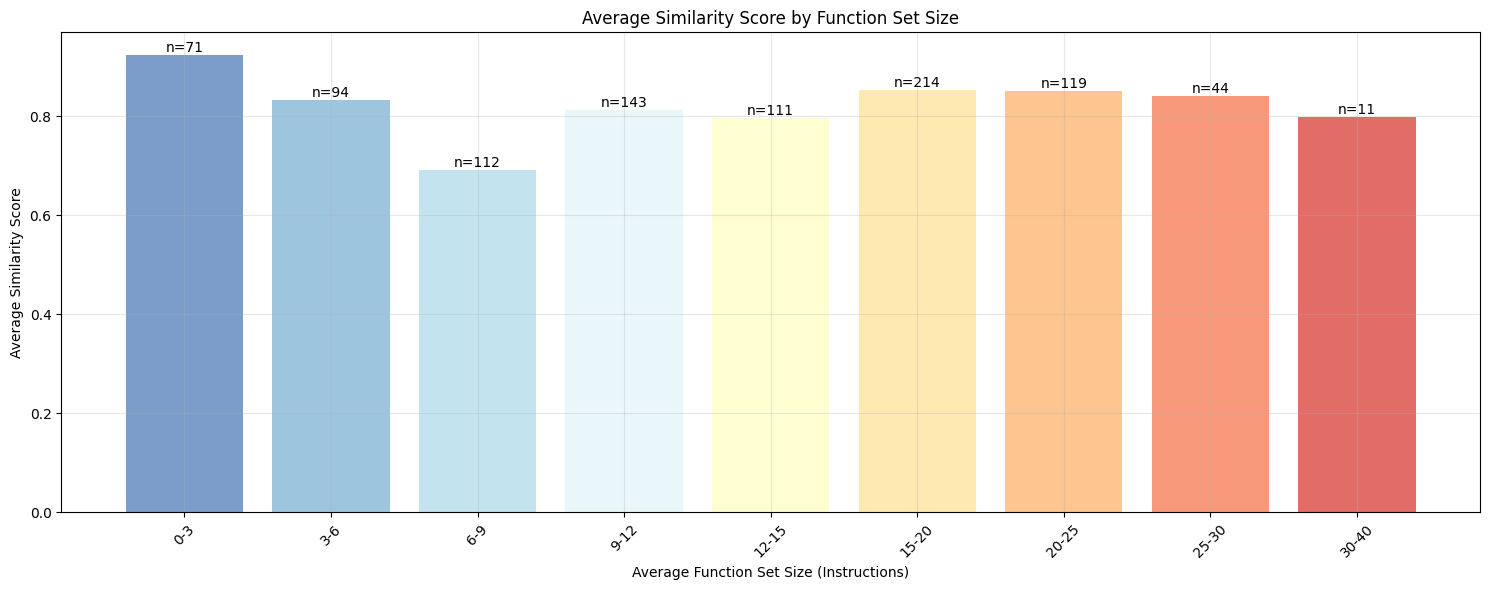


Correlation Analysis:
Pearson correlation coefficient: 0.065
P-value: 0.050

Basic Statistics:
Total number of functions: 919
Average function set size: 13.63
Median function set size: 13.50
Average similarity score: 0.822


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

# 讀取 CSV 檔案
df = pd.read_csv('/home/tommy/cross-architecture/Experiment1/src/scripts_with-fno-common＿20250210/ghidra/automation_20250210/results/compare/Jascard_pcode_similarity_20250210_113636_arm_vs_mips_20250214_103035.csv')

# 計算 function set 的平均大小
df['Avg_Set_Size'] = (df['ARM Set Size'] + df['MIPS Set Size']) / 2

# 將 function set size 分組（每 5 個為一組）
custom_bins = [0, 3, 6, 9, 12, 15, 20, 25, 30, 40]
df['Size_Group'] = pd.cut(df['Avg_Set_Size'], bins=custom_bins)

# 計算每組的平均相似度和數量
size_sim_relation = df.groupby('Size_Group').agg({
    'Similarity Score': ['mean', 'count']
}).reset_index()

# 只顯示有數據的組
size_sim_relation = size_sim_relation[size_sim_relation[('Similarity Score', 'count')] > 0]

colors = sns.color_palette("RdYlBu_r", n_colors=len(size_sim_relation))

# 繪製長條圖
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(size_sim_relation)), 
               size_sim_relation[('Similarity Score', 'mean')], 
               width=0.8, 
               color=colors, 
               alpha=0.7)

# 設定 x 軸標籤
plt.xticks(range(len(size_sim_relation)), 
           [f"{int(interval.left)}-{int(interval.right)}" for interval in size_sim_relation['Size_Group']], 
           rotation=45)

# 在每個長條上標註數量
for i, bar in enumerate(bars):
    count = int(size_sim_relation[('Similarity Score', 'count')][i])
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(),
             f'n={count}',
             ha='center', 
             va='bottom')

# 添加標題和標籤
plt.title('Average Similarity Score by Function Set Size')
plt.xlabel('Average Function Set Size (Instructions)')
plt.ylabel('Average Similarity Score')

# 添加網格線
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 輸出相關係數
correlation = stats.pearsonr(df['Avg_Set_Size'], df['Similarity Score'])
print("\nCorrelation Analysis:")
print(f"Pearson correlation coefficient: {correlation[0]:.3f}")
print(f"P-value: {correlation[1]:.3f}")

# 輸出基本統計信息
print("\nBasic Statistics:")
print(f"Total number of functions: {len(df)}")
print(f"Average function set size: {df['Avg_Set_Size'].mean():.2f}")
print(f"Median function set size: {df['Avg_Set_Size'].median():.2f}")
print(f"Average similarity score: {df['Similarity Score'].mean():.3f}")

/tmp/ipykernel_3375128/2451977220.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  arm_relation = df.groupby('ARM_Group').agg({
/tmp/ipykernel_3375128/2451977220.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mips_relation = df.groupby('MIPS_Group').agg({


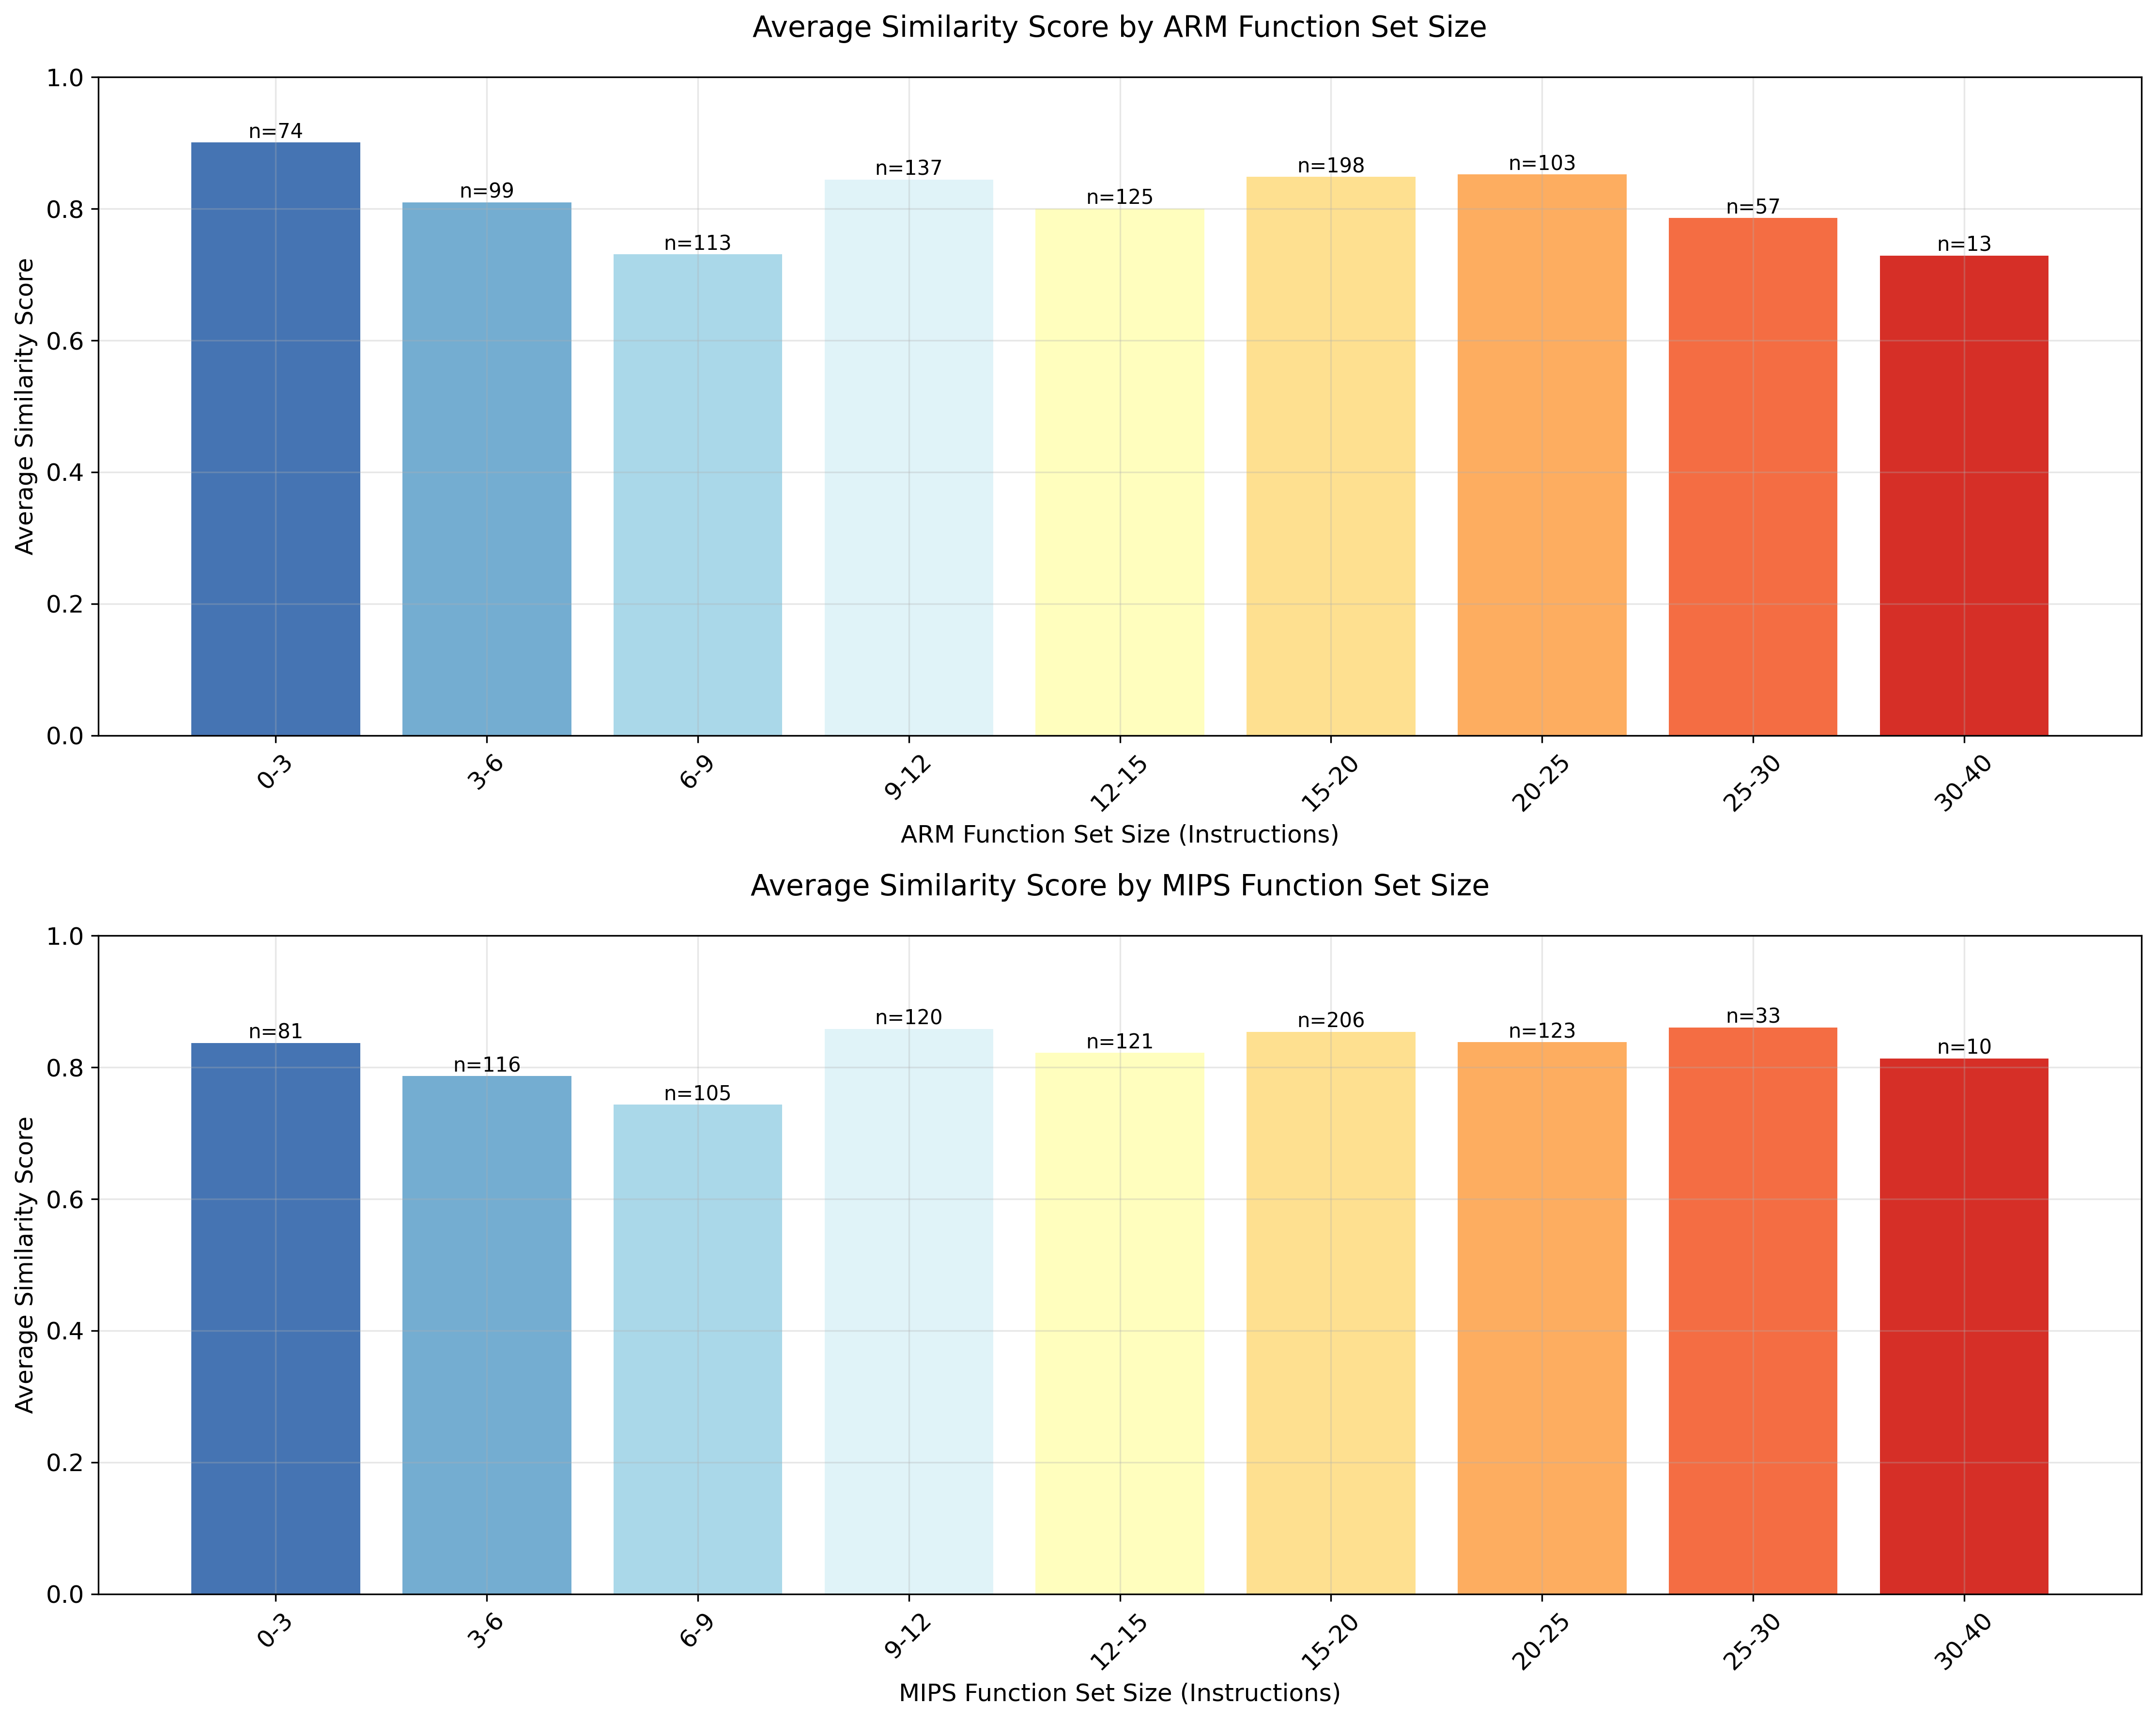


ARM Correlation Analysis:
Pearson correlation coefficient: -0.003
P-value: 0.933

MIPS Correlation Analysis:
Pearson correlation coefficient: 0.131
P-value: 0.000

Basic Statistics:
Total number of functions: 919
Average ARM function set size: 13.85
Median ARM function set size: 13.00
Average MIPS function set size: 13.42
Median MIPS function set size: 13.00
Average similarity score: 0.822


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

# 讀取 CSV 檔案
df = pd.read_csv('/home/tommy/cross-architecture/Experiment1/src/scripts_with-fno-common＿20250210/ghidra/automation_20250210/results/compare/Jascard_pcode_similarity_20250210_113636_arm_vs_mips_20250214_103035.csv')

# 設定字體大小
plt.rcParams.update({'font.size': 12})

# 自定義區間
custom_bins = [0, 3, 6, 9, 12, 15, 20, 25, 30, 40]

# 創建一個圖表，包含兩個子圖
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), dpi=300)

# ARM 分析
df['ARM_Group'] = pd.cut(df['ARM Set Size'], bins=custom_bins)
arm_relation = df.groupby('ARM_Group').agg({
    'Similarity Score': ['mean', 'count']
}).reset_index()
arm_relation = arm_relation[arm_relation[('Similarity Score', 'count')] > 0]

# MIPS 分析
df['MIPS_Group'] = pd.cut(df['MIPS Set Size'], bins=custom_bins)
mips_relation = df.groupby('MIPS_Group').agg({
    'Similarity Score': ['mean', 'count']
}).reset_index()
mips_relation = mips_relation[mips_relation[('Similarity Score', 'count')] > 0]

# 創建顏色漸層
arm_colors = sns.color_palette("RdYlBu_r", n_colors=len(arm_relation))
mips_colors = sns.color_palette("RdYlBu_r", n_colors=len(mips_relation))

# 繪製 ARM 圖表
bars1 = ax1.bar(range(len(arm_relation)), 
                arm_relation[('Similarity Score', 'mean')], 
                width=0.8, 
                color=arm_colors)

# 設定 ARM x 軸標籤
ax1.set_xticks(range(len(arm_relation)))
ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" 
                     for interval in arm_relation['ARM_Group']], 
                    rotation=45)

# 在 ARM 長條上標註數量
for i, bar in enumerate(bars1):
    count = int(arm_relation[('Similarity Score', 'count')][i])
    ax1.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(),
             f'n={count}',
             ha='center', 
             va='bottom',
             fontsize=10)

# 繪製 MIPS 圖表
bars2 = ax2.bar(range(len(mips_relation)), 
                mips_relation[('Similarity Score', 'mean')], 
                width=0.8, 
                color=mips_colors)

# 設定 MIPS x 軸標籤
ax2.set_xticks(range(len(mips_relation)))
ax2.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" 
                     for interval in mips_relation['MIPS_Group']], 
                    rotation=45)

# 在 MIPS 長條上標註數量
for i, bar in enumerate(bars2):
    count = int(mips_relation[('Similarity Score', 'count')][i])
    ax2.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(),
             f'n={count}',
             ha='center', 
             va='bottom',
             fontsize=10)

# 設定標題和標籤
ax1.set_title('Average Similarity Score by ARM Function Set Size', pad=20)
ax1.set_xlabel('ARM Function Set Size (Instructions)')
ax1.set_ylabel('Average Similarity Score')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

ax2.set_title('Average Similarity Score by MIPS Function Set Size', pad=20)
ax2.set_xlabel('MIPS Function Set Size (Instructions)')
ax2.set_ylabel('Average Similarity Score')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()

# 儲存為 SVG 格式
plt.savefig('function_similarity_analysis.svg', format='svg', bbox_inches='tight')
plt.show()

# 輸出相關係數
arm_correlation = stats.pearsonr(df['ARM Set Size'], df['Similarity Score'])
mips_correlation = stats.pearsonr(df['MIPS Set Size'], df['Similarity Score'])

print("\nARM Correlation Analysis:")
print(f"Pearson correlation coefficient: {arm_correlation[0]:.3f}")
print(f"P-value: {arm_correlation[1]:.3f}")

print("\nMIPS Correlation Analysis:")
print(f"Pearson correlation coefficient: {mips_correlation[0]:.3f}")
print(f"P-value: {mips_correlation[1]:.3f}")

# 輸出基本統計信息
print("\nBasic Statistics:")
print(f"Total number of functions: {len(df)}")
print(f"Average ARM function set size: {df['ARM Set Size'].mean():.2f}")
print(f"Median ARM function set size: {df['ARM Set Size'].median():.2f}")
print(f"Average MIPS function set size: {df['MIPS Set Size'].mean():.2f}")
print(f"Median MIPS function set size: {df['MIPS Set Size'].median():.2f}")
print(f"Average similarity score: {df['Similarity Score'].mean():.3f}")

/tmp/ipykernel_3375128/4080537070.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  arm_relation = df.groupby('ARM_Group').agg({
/tmp/ipykernel_3375128/4080537070.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mips_relation = df.groupby('MIPS_Group').agg({


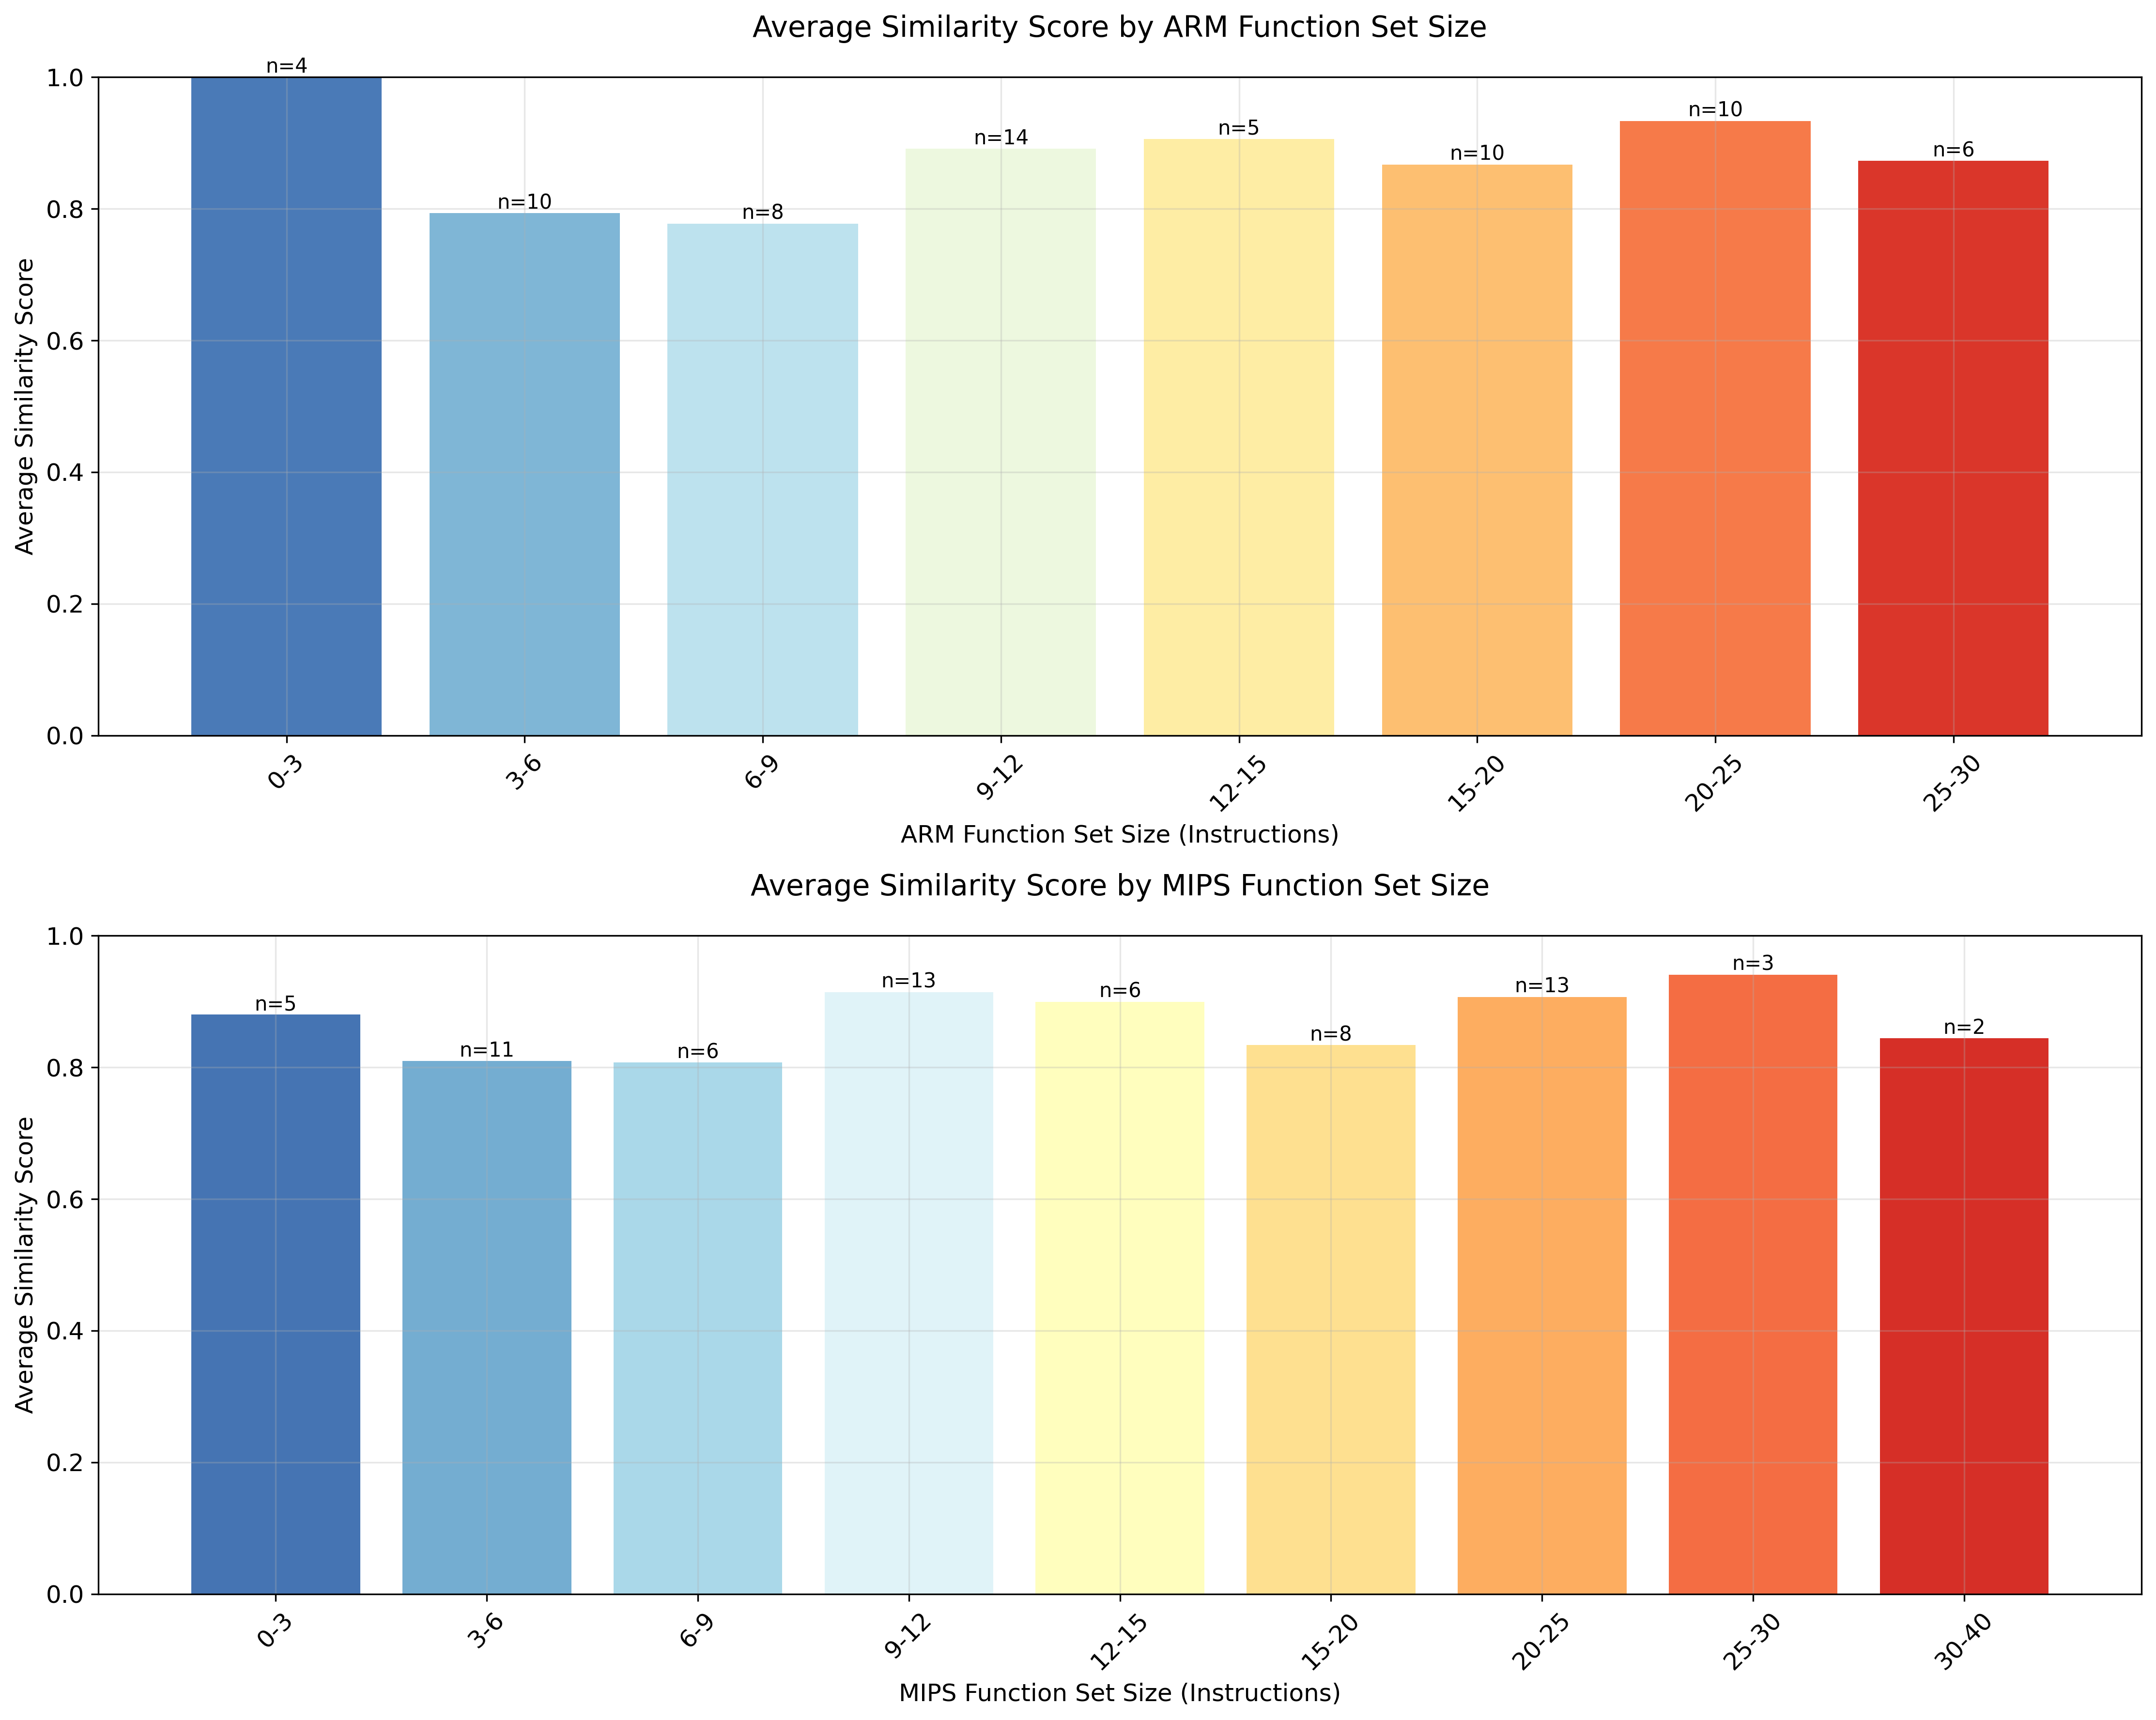


ARM Correlation Analysis:
Pearson correlation coefficient: 0.169
P-value: 0.172

MIPS Correlation Analysis:
Pearson correlation coefficient: 0.139
P-value: 0.262

Basic Statistics:
Total number of functions: 67
Average ARM function set size: 13.69
Median ARM function set size: 12.00
Average MIPS function set size: 14.18
Median MIPS function set size: 12.00
Average similarity score: 0.872


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

# 讀取 CSV 檔案
df = pd.read_csv('/home/tommy/cross-architecture/Experiment1/src/scripts_with-fno-common＿20250210/ghidra/automation_20250210/results/compare/Jascard_pcode_similarity_20250210_113636_arm_vs_mips_20250214_103035.csv')

# 過濾出 UserDefined 為 1 的資料
df = df[df['UserDefined'] == 1]

# 設定字體大小
plt.rcParams.update({'font.size': 12})

# 自定義區間
custom_bins = [0, 3, 6, 9, 12, 15, 20, 25, 30, 40]

# 創建一個圖表，包含兩個子圖
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), dpi=300)

# ARM 分析
df['ARM_Group'] = pd.cut(df['ARM Set Size'], bins=custom_bins)
arm_relation = df.groupby('ARM_Group').agg({
    'Similarity Score': ['mean', 'count']
}).reset_index()
arm_relation = arm_relation[arm_relation[('Similarity Score', 'count')] > 0]

# MIPS 分析
df['MIPS_Group'] = pd.cut(df['MIPS Set Size'], bins=custom_bins)
mips_relation = df.groupby('MIPS_Group').agg({
    'Similarity Score': ['mean', 'count']
}).reset_index()
mips_relation = mips_relation[mips_relation[('Similarity Score', 'count')] > 0]

# 創建顏色漸層
arm_colors = sns.color_palette("RdYlBu_r", n_colors=len(arm_relation))
mips_colors = sns.color_palette("RdYlBu_r", n_colors=len(mips_relation))

# 繪製 ARM 圖表
bars1 = ax1.bar(range(len(arm_relation)), 
                arm_relation[('Similarity Score', 'mean')], 
                width=0.8, 
                color=arm_colors)

# 設定 ARM x 軸標籤
ax1.set_xticks(range(len(arm_relation)))
ax1.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" 
                     for interval in arm_relation['ARM_Group']], 
                    rotation=45)

# 在 ARM 長條上標註數量
for i, bar in enumerate(bars1):
    count = int(arm_relation[('Similarity Score', 'count')][i])
    ax1.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(),
             f'n={count}',
             ha='center', 
             va='bottom',
             fontsize=10)

# 繪製 MIPS 圖表
bars2 = ax2.bar(range(len(mips_relation)), 
                mips_relation[('Similarity Score', 'mean')], 
                width=0.8, 
                color=mips_colors)

# 設定 MIPS x 軸標籤
ax2.set_xticks(range(len(mips_relation)))
ax2.set_xticklabels([f"{int(interval.left)}-{int(interval.right)}" 
                     for interval in mips_relation['MIPS_Group']], 
                    rotation=45)

# 在 MIPS 長條上標註數量
for i, bar in enumerate(bars2):
    count = int(mips_relation[('Similarity Score', 'count')][i])
    ax2.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(),
             f'n={count}',
             ha='center', 
             va='bottom',
             fontsize=10)

# 設定標題和標籤
ax1.set_title('Average Similarity Score by ARM Function Set Size(User-defined)', pad=20)
ax1.set_xlabel('ARM Function Set Size (Instructions)')
ax1.set_ylabel('Average Similarity Score')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

ax2.set_title('Average Similarity Score by MIPS Function Set Size(User-defined)', pad=20)
ax2.set_xlabel('MIPS Function Set Size (Instructions)')
ax2.set_ylabel('Average Similarity Score')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()

# 儲存為 SVG 格式
plt.savefig('function_similarity_analysis.svg', format='svg', bbox_inches='tight')
plt.show()

# 輸出相關係數
arm_correlation = stats.pearsonr(df['ARM Set Size'], df['Similarity Score'])
mips_correlation = stats.pearsonr(df['MIPS Set Size'], df['Similarity Score'])

print("\nARM Correlation Analysis:")
print(f"Pearson correlation coefficient: {arm_correlation[0]:.3f}")
print(f"P-value: {arm_correlation[1]:.3f}")

print("\nMIPS Correlation Analysis:")
print(f"Pearson correlation coefficient: {mips_correlation[0]:.3f}")
print(f"P-value: {mips_correlation[1]:.3f}")

# 輸出基本統計信息
print("\nBasic Statistics:")
print(f"Total number of functions: {len(df)}")
print(f"Average ARM function set size: {df['ARM Set Size'].mean():.2f}")
print(f"Median ARM function set size: {df['ARM Set Size'].median():.2f}")
print(f"Average MIPS function set size: {df['MIPS Set Size'].mean():.2f}")
print(f"Median MIPS function set size: {df['MIPS Set Size'].median():.2f}")
print(f"Average similarity score: {df['Similarity Score'].mean():.3f}")
